<a href="https://colab.research.google.com/github/mthSolon/Data_Science/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Lendo dataset

In [ ]:
titanic = pd.read_csv('train.csv')
titanic.drop('PassengerId', axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
titanic.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"O'Sullivan, Miss. Bridget Mary",male,1601,B96 B98,S
freq,1,577,7,4,644


In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


# Visualização

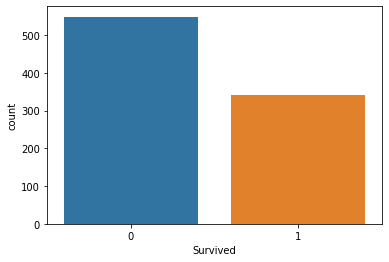

In [ ]:
sns.countplot(data=titanic, x='Survived');

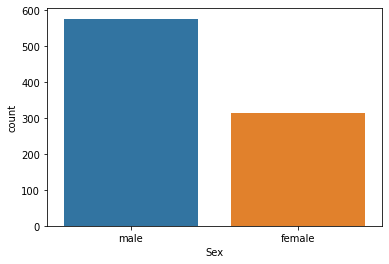

In [ ]:
sns.countplot(data=titanic, x='Sex');

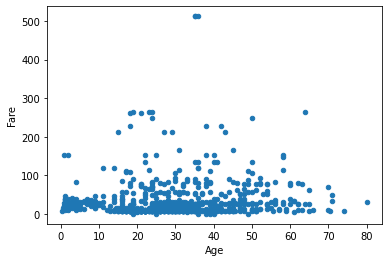

In [ ]:
titanic.plot(kind='scatter', x='Age', y='Fare');

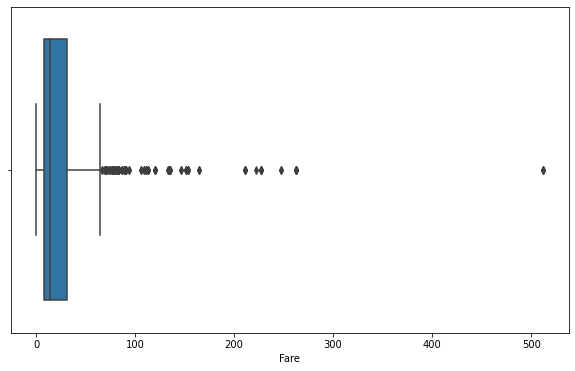

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=titanic, x='Fare');

In [ ]:
titanic.corr()['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [ ]:
titanic.isna().sum() # Muitos valores faltantes em "Cabin"

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Algo notável aqui é a correlação positiva em "Parch" e a correlação negativa em "SibSp". Possivelmente, passageiros que possuíam pais(eram crianças) tiveram mais chances de sobrevivência porque crianças tinham prioridade nas operações de resgate.

# Divisão previsores e classe

In [ ]:
X = titanic.drop('Survived', axis=1)
y = titanic['Survived'].copy()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# Tratamento dos dados

In [ ]:
num_features = list(X.select_dtypes(exclude='object'))
cat_features = list(X.select_dtypes(include='object'))
cat_features.remove('Cabin'), cat_features.remove('Name'), cat_features.remove('Ticket')
cabin_name_ticket_features = ['Cabin', 'Name', 'Ticket']

In [ ]:
num_features, cat_features, cabin_name_ticket_features

(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Sex', 'Embarked'],
 ['Cabin', 'Name', 'Ticket'])

In [ ]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])
cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
class CabinNameTicketRemover(BaseEstimator, TransformerMixin):
  def __init__(self):
    print('CabinNameTicketRemover initialized.')

  def fit(self, X, y=None):
    print('Fit initialized')
    return self
  
  def transform(self, X, y=None):
    print('Transformer initialized')
    return X.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [ ]:
full_pipeline = ColumnTransformer([
                                 ('num', num_pipeline, num_features),
                                 ('cat', cat_pipeline, cat_features),
                                 ('cabin_name', CabinNameTicketRemover(), cabin_name_ticket_features)])

CabinNameTicketRemover initialized.


In [ ]:
X_train_prepared = full_pipeline.fit_transform(X_train)

CabinNameTicketRemover initialized.
Fit initialized
Transformer initialized


# Aplicação dos modelos

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
tree_clf = DecisionTreeClassifier()
random_clf = RandomForestClassifier()
log_clf = LogisticRegression()
svm_clf = SVC()
knn_clf = KNeighborsClassifier()

In [ ]:
tree_clf.fit(X_train_prepared, y_train)
random_clf.fit(X_train_prepared, y_train)
log_clf.fit(X_train_prepared, y_train)
svm_clf.fit(X_train_prepared, y_train)
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier()

In [ ]:
previsores_tree = tree_clf.predict(full_pipeline.transform(X_valid))
previsores_random = random_clf.predict(full_pipeline.transform(X_valid))
previsores_log = log_clf.predict(full_pipeline.transform(X_valid))
previsores_svm = svm_clf.predict(full_pipeline.transform(X_valid))
previsores_knn = knn_clf.predict(full_pipeline.transform(X_valid))

Transformer initialized
Transformer initialized
Transformer initialized
Transformer initialized
Transformer initialized


In [ ]:
def display_report(name, pred):
  print(f'{name}: {classification_report(y_valid, pred)}')

In [ ]:
display_report('tree', previsores_tree)
display_report('random', previsores_random)
display_report('log', previsores_log)
display_report('svm', previsores_svm)
display_report('knn', previsores_knn)

tree:               precision    recall  f1-score   support

           0       0.81      0.84      0.82       112
           1       0.71      0.67      0.69        67

    accuracy                           0.78       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.78      0.78       179

random:               precision    recall  f1-score   support

           0       0.80      0.84      0.82       112
           1       0.70      0.64      0.67        67

    accuracy                           0.77       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.76      0.77      0.76       179

log:               precision    recall  f1-score   support

           0       0.81      0.82      0.82       112
           1       0.70      0.69      0.69        67

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



# Validação cruzada com o cross_val_predict

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [ ]:
X_full_prepared = full_pipeline.transform(X)

Transformer initialized


In [ ]:
def display_cm(name, y_pred):
  print(f'Model: {name}')
  print(confusion_matrix(y, y_pred))
  print(f'Precision: {precision_score(y, y_pred)}')
  print(f'Recall: {recall_score(y, y_pred)}')
  print(f'F1 Score: {f1_score(y, y_pred)}\n')

In [ ]:
scores_tree = cross_val_predict(tree_clf, X_full_prepared, y, cv=30)
scores_random = cross_val_predict(random_clf, X_full_prepared, y, cv=30)
scores_log = cross_val_predict(log_clf, X_full_prepared, y, cv=30)
scores_svm = cross_val_predict(svm_clf, X_full_prepared, y, cv=30)
scores_knn = cross_val_predict(knn_clf, X_full_prepared, y, cv=30)

In [ ]:
display_cm('tree',scores_tree)
display_cm('random',scores_random)
display_cm('log', scores_log)
display_cm('svm', scores_svm)
display_cm('knn', scores_knn)

Model: tree
[[466  83]
 [ 96 246]]
Precision: 0.7477203647416414
Recall: 0.7192982456140351
F1 Score: 0.7332339791356185

Model: random
[[469  80]
 [ 94 248]]
Precision: 0.7560975609756098
Recall: 0.7251461988304093
F1 Score: 0.7402985074626864

Model: log
[[470  79]
 [103 239]]
Precision: 0.7515723270440252
Recall: 0.6988304093567251
F1 Score: 0.7242424242424242

Model: svm
[[493  56]
 [105 237]]
Precision: 0.8088737201365188
Recall: 0.6929824561403509
F1 Score: 0.746456692913386

Model: knn
[[477  72]
 [101 241]]
Precision: 0.7699680511182109
Recall: 0.7046783625730995
F1 Score: 0.7358778625954198



No problema do titanic temos a classe de não-sobreviventes(0) e de sobreviventes(1). Portanto, é preferível um modelo que desempenhe bem em identificar aqueles que não sobreviveram, ou seja, que possua um bom recall.

Por isso, escolherei o Random Forest.

# Tuning do modelo

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
RandomForestClassifier()

In [ ]:
param = [
    {'n_estimators': [3, 10, 25, 50, 100, 150], 'criterion': ['gini', 'entropy'], 'min_samples_split': [0.5, 2, 5], 'max_features': [1, 2, 4, 6, 'auto']},
    {'bootstrap': [False], 'n_estimators': [10, 50, 100], 'min_samples_split': [0.5, 3, 5], 'max_features': [2, 3, 4, 'auto']}]

forest_clf = RandomForestClassifier()
grid = GridSearchCV(forest_clf, param, cv=5)
grid.fit(X_full_prepared, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': [1, 2, 4, 6, 'auto'],
                          'min_samples_split': [0.5, 2, 5],
                          'n_estimators': [3, 10, 25, 50, 100, 150]},
                         {'bootstrap': [False],
                          'max_features': [2, 3, 4, 'auto'],
                          'min_samples_split': [0.5, 3, 5],
                          'n_estimators': [10, 50, 100]}])

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_features': 6,
 'min_samples_split': 5,
 'n_estimators': 150}

In [ ]:
final_model = grid.best_estimator_

# Aplicando o modelo nos dados de teste

In [ ]:
test = pd.read_csv('test.csv')
X_test = test.drop('PassengerId', axis=1)

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)

Transformer initialized


In [ ]:
previsao_final = final_model.predict(X_test_prepared)
previsao_final

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = previsao_final
submission.to_csv('submission.csv', index=False)